# Prophet modeling

Here we'll try to mimic the same process of finding the best train-test split, but for Facebook's Prophet library. Let's import everything.

In [29]:
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from sklearn.linear_model import LinearRegression
from iexfinance.stocks import Stock
import random
#from trafalgar import*
import pandas as pd
import pandas.tseries
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
import datetime as dt
from datetime import date
from datetime import timedelta 
import yfinance as yf
import requests
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split
from pandas.plotting import lag_plot
from pandas import datetime
import re
from tiingo import TiingoClient
import json
from pandas_datareader import data as pdr

In [30]:
yf.__version__

'0.1.63'

### The test case: C
Just like the previous notebook, we'll try to run through a simple test case and expand it to other stocks. We'll use Citicgroup again.

Quick note: I encountered a bug with my earlier library, yfinance, so I've had to switch to tiingo, so a lot of code will be hashed out from earlier. And in case I can get the bugs worked out.

In [31]:
c = yf.Ticker("C")

In [32]:
df=c.history(period="2y")

In [33]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-17,66.404265,66.693423,65.872583,66.059135,12278200,0.0,0
2019-07-18,65.797982,67.066557,65.742018,66.963951,13407400,0.0,0
2019-07-19,66.907973,67.318389,66.096456,66.152420,11184600,0.0,0
2019-07-22,65.965877,66.497558,65.928565,66.329659,7930600,0.0,0
2019-07-23,66.534877,67.327735,66.506895,67.150505,11804300,0.0,0


In [34]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-17,66.404265,66.693423,65.872583,66.059135,12278200,0.0,0
2019-07-18,65.797982,67.066557,65.742018,66.963951,13407400,0.0,0
2019-07-19,66.907973,67.318389,66.096456,66.152420,11184600,0.0,0
2019-07-22,65.965877,66.497558,65.928565,66.329659,7930600,0.0,0
2019-07-23,66.534877,67.327735,66.506895,67.150505,11804300,0.0,0


In [35]:
deltas=['d','m','y']
att='200d'

In [36]:
att[-1]

'd'

In [37]:
spl=len(att)-1
att[:spl]

'200'

In [38]:
end=att[:spl] + ' days'
end

'200 days'

In [39]:
df1=df['Close']

In [40]:
df1.head()

Date
2019-07-17    66.059135
2019-07-18    66.963951
2019-07-19    66.152420
2019-07-22    66.329659
2019-07-23    67.150505
Name: Close, dtype: float64

In [41]:
df1=df1.to_frame()

In [42]:
# instantiate Prophet
prof_1 = Prophet()

In [43]:
df1.head()

,Close
Date,
2019-07-17,66.059135
2019-07-18,66.963951
2019-07-19,66.152420
2019-07-22,66.329659
2019-07-23,67.150505


In [44]:
df1.index.names = ['ds']
df1.columns=['y']

In [45]:
df1.reset_index(level=0, inplace=True)

In [46]:
df1.head()

,ds,y
0,2019-07-17,66.059135
1,2019-07-18,66.963951
2,2019-07-19,66.152420
3,2019-07-22,66.329659
4,2019-07-23,67.150505


In [47]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      505 non-null    datetime64[ns]
 1   y       505 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


In [48]:
prof_1.fit(df1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [49]:
#Create a new dataframe for the predictions, 3 weeks out
future = prof_1.make_future_dataframe(periods=21)

In [50]:
forecast = prof_1.predict(future)

In [51]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
521,2021-08-02,75.238021,71.556025,81.368006,75.032201,75.424817,0.711930,0.711930,0.711930,-0.430478,-0.430478,-0.430478,1.142408,1.142408,1.142408,0.0,0.0,0.0,75.949951
522,2021-08-03,75.310363,70.296904,80.485127,75.083586,75.528783,0.166397,0.166397,0.166397,-0.652423,-0.652423,-0.652423,0.818820,0.818820,0.818820,0.0,0.0,0.0,75.476761
523,2021-08-04,75.382706,69.996725,80.509996,75.123003,75.630446,-0.092185,-0.092185,-0.092185,-0.569478,-0.569478,-0.569478,0.477293,0.477293,0.477293,0.0,0.0,0.0,75.290521
524,2021-08-05,75.455048,70.133790,79.880694,75.161106,75.719389,-0.473197,-0.473197,-0.473197,-0.596291,-0.596291,-0.596291,0.123094,0.123094,0.123094,0.0,0.0,0.0,74.981851
525,2021-08-06,75.527391,69.573756,79.775514,75.195173,75.830308,-0.883225,-0.883225,-0.883225,-0.644813,-0.644813,-0.644813,-0.238412,-0.238412,-0.238412,0.0,0.0,0.0,74.644165


In [52]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          526 non-null    datetime64[ns]
 1   trend                       526 non-null    float64       
 2   yhat_lower                  526 non-null    float64       
 3   yhat_upper                  526 non-null    float64       
 4   trend_lower                 526 non-null    float64       
 5   trend_upper                 526 non-null    float64       
 6   additive_terms              526 non-null    float64       
 7   additive_terms_lower        526 non-null    float64       
 8   additive_terms_upper        526 non-null    float64       
 9   weekly                      526 non-null    float64       
 10  weekly_lower                526 non-null    float64       
 11  weekly_upper                526 non-null    float64       

In [53]:
proph_pred=forecast['yhat']

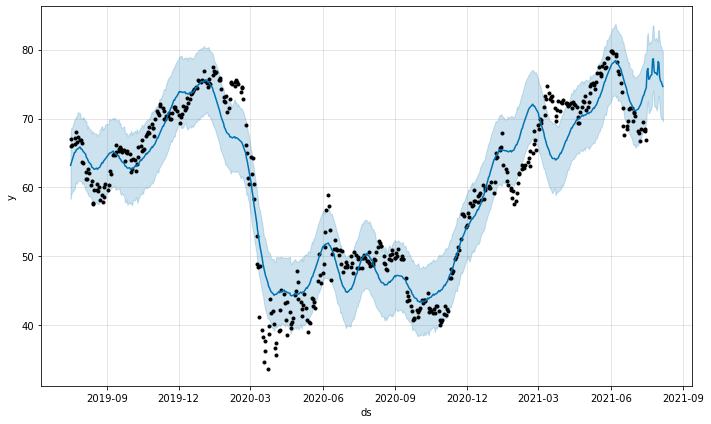

In [54]:
prof_1.plot(forecast)
plt.show()

In [55]:
df1_cv = cross_validation(prof_1, initial='30 days', period='7 days', horizon = '14 days')

INFO:prophet:Making 99 forecasts with cutoffs between 2019-08-16 00:00:00 and 2021-07-02 00:00:00


  0%|          | 0/99 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


In [56]:
df1_pm = performance_metrics(df1_cv)

In [57]:
trains=['30 days','60 days','180 days']
tests=['7 days','14 days','21 days']

In [58]:
df1_pm.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
4,10 days,462.266008,21.500372,13.215665,0.224003,0.131071,0.225935,0.162486
5,11 days,814.790142,28.544529,16.399145,0.277409,0.160237,0.271908,0.111111
6,12 days,1236.533109,35.164373,19.374418,0.328088,0.171952,0.303072,0.092784
7,13 days,1777.974486,42.166035,21.558369,0.360251,0.150457,0.310805,0.113402
8,14 days,2624.991535,51.234671,25.013462,0.410445,0.172395,0.334157,0.095931


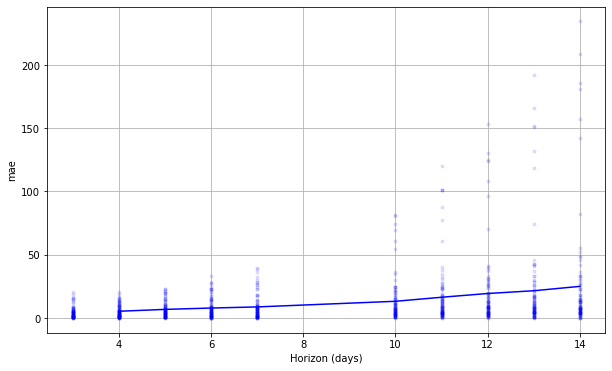

In [59]:
fig = plot_cross_validation_metric(df1_cv, metric='mae')

## STONKS (Again)!!!

Just like in the ARIMA notebook, I want to test a number of train-test splits with Prophet. Since it works a little different from ARIMA, the code will be a little different, but still borrowing a lot. Here, we can import our stock symbols, and clean them up.

In [60]:
sp_500=pd.read_csv('Data/constituents_csv.csv')
nsdq=pd.read_csv('Data/nasdaq1.csv')
dow_30=pd.read_excel('Data/dow-jones-industrial-average-components.xls')

In [61]:
new_cols=['Name','Symbol','Weight%']
dow_30.columns=new_cols

In [62]:
nsdq.head()

,Unnamed: 0,Symbol,Company Name
0,0,AAIT,iShares MSCI All Country Asia Information Tech...
1,1,AAL,"American Airlines Group, Inc."
2,2,AAME,Atlantic American Corporation
3,3,AAOI,"Applied Optoelectronics, Inc."
4,4,AAON,"AAON, Inc."


In [63]:
nsdq.drop(columns='Unnamed: 0',inplace=True)

In [64]:
len(nsdq)

1734

The following cells were necessary for cleaning the nasdaq stock list. But I saved it, and that's what I'm using.

In [65]:
#no_data=[]
#for each in nsdq['Symbol']:
#    x=yf.Ticker(each)
#    df=x.history(period='1d')
#    if len(df)==0:
#        no_data.append(each)

In [66]:
#len(no_data)

In [67]:
#nd_index=[]
#for each in no_data:
#    y=nsdq.loc[nsdq['Symbol']==each].index
#    nd_index.append(y[0])

In [68]:
#nsdq = nsdq.drop(labels=nd_index,drop=True, axis=0)
#nsdq.reset_index()

In [69]:
#nsdq.to_csv("/Users/Daniel/Documents/Flatiron/Capstone/Project/nasdaq1.csv")

In [70]:
def tt_test_p (asset,train_val,test_val):
    """This function will take in a financial asset (stock, etf) as well as 2 lists of integers (training and testing days).
    Then the asset will be looked up through yahoo finance and gather the price history. It will then run through the values
    of the training and testing lists and run prophet models on all of them. It will record the metrics and return a
    dataframe with all the results."""
    
    stock = yf.Ticker(asset)
    df1=stock.history(period='2y')
    print("Processing: ",stock)
    prof_1 = Prophet()
    df1=df1['Close']
    df1=df1.to_frame()
    df1.index.names = ['ds']
    df1.columns=['y']
    df1.reset_index(level=0, inplace=True)
    prof_1.fit(df1)
    future = prof_1.make_future_dataframe(periods=21)
    forecast = prof_1.predict(future)
    for train_val in trains:
        for test_val in tests:
            df1_cv = cross_validation(prof_1, initial=train_val, period=test_val, horizon = '21 days')
            df1_pm = performance_metrics(df1_cv)
            print('Training: ', train_val)
            print('Testing: ', test_val)
            print (df1_pm.tail())             

    return forecast

In [71]:
cols2=['Symbol','Train_Len','Test_Len','MAE','RMSE']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()

,index,Symbol,Train_Len,Test_Len,MAE,RMSE


In [72]:
results_CAT=tt_test_p('CAT',trains,tests)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing:  yfinance.Ticker object <CAT>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-16 00:00:00 and 2021-06-25 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-08-23 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   28891.650433  169.975441   67.785273  0.512688  0.147571   
10 18 days   44742.635870  211.524551   83.430693  0.634614  0.122784   
11 19 days   59091.557107  243.087550   95.165131  0.725074  0.127461   
12 20 days   77139.146637  277.739350  107.107750  0.817530  0.121448   
13 21 days  100268.751544  316.652414  121.498740  0.919880  0.124687   

       smape  coverage  
9   0.346770  0.144589  
10  0.381358  0.140410  
11  0.404467  0.137791  
12  0.423638  0.114140  
13  0.449563  0.085106  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-08-23 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
9  17 days  20135.897895  141.901014   67.814899  0.517443  0.133912   
10 18 days  30454.111940  174.511065   80.833292  0.613907  0.142222   
11 19 days  40273.786515  200.683299   90.640234  0.684201  0.135955   
12 20 days  51851.757006  227.709809  100.457982  0.756417  0.156703   
13 21 days  68408.400259  261.549996  114.342157  0.851804  0.149690   

       smape  coverage  
9   0.403526  0.134852  
10  0.425865  0.138148  
11  0.441064  0.116700  
12  0.456275  0.102700  
13  0.483995  0.078183  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-09-20 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  21 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  17 days   7137.941492   84.486339  46.573929  0.347437  0.122722  0.315388   
10 18 days  10259.453287  101.288959  55.036959  0.411202  0.122722  0.342257   
11 19 days  13189.003279  114.843386  62.036748  0.462232  0.137418  0.369027   
12 20 days  16638.951838  128.992061  68.884027  0.518012  0.137994  0.396194   
13 21 days  21372.094989  146.191980  77.645522  0.581319  0.162528  0.430792   

    coverage  
9   0.159574  
10  0.123542  
11  0.123791  
12  0.125000  
13  0.130319  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-09-20 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  7 days
   horizon           mse        rmse         mae      mape     mdape  \
9  17 days  25507.378782  159.710296   59.735094  0.445871  0.132742   
10 18 days  38831.315734  197.056631   71.696652  0.535670  0.133729   
11 19 days  51119.856983  226.097008   80.745788  0.602871  0.122387   
12 20 days  67025.925550  258.893657   90.644153  0.678793  0.131322   
13 21 days  87483.783596  295.776577  102.632189  0.760092  0.137177   

       smape  coverage  
9   0.307967  0.151883  
10  0.336317  0.147673  
11  0.354471  0.152784  
12  0.370633  0.123995  
13  0.392784  0.097425  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
9  17 days  19738.350948  140.493242   64.608356  0.488900  0.145206   
10 18 days  29790.183786  172.598331   76.588844  0.577505  0.137400   
11 19 days  39347.035701  198.360872   85.606561  0.642256  0.135151   
12 20 days  50633.223858  225.018274   94.637173  0.707866  0.130896   
13 21 days  66867.988985  258.588455  107.546942  0.795310  0.152299   

       smape  coverage  
9   0.369546  0.140850  
10  0.392210  0.144118  
11  0.407133  0.121715  
12  0.422279  0.107097  
13  0.448955  0.081665  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-17 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  21 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  17 days   5553.717363   74.523267  39.506296  0.286039  0.110970  0.240353   
10 18 days   7812.079721   88.385970  46.201863  0.336290  0.095279  0.263481   
11 19 days   9876.906347   99.382626  51.854774  0.377349  0.096605  0.285853   
12 20 days  12294.607628  110.881052  57.188922  0.420738  0.111415  0.307286   
13 21 days  15596.756115  124.886973  63.940406  0.468325  0.129353  0.332675   

    coverage  
9   0.193182  
10  0.141850  
11  0.131965  
12  0.133333  
13  0.139394  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-01-24 00:00:00 and 2021-06-25 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1618.375302  40.229036  25.752691  0.193847  0.087409  0.194740   
10 18 days  2227.116509  47.192335  28.834391  0.218574  0.090810  0.218515   
11 19 days  2704.000144  52.000001  31.182558  0.235315  0.113453  0.235358   
12 20 days  3048.004734  55.208738  33.043712  0.249891  0.119090  0.249068   
13 21 days  3538.074674  59.481717  35.455735  0.269309  0.107072  0.267164   

    coverage  
9   0.173496  
10  0.167457  
11  0.161962  
12  0.141148  
13  0.101818  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-17 00:00:00 and 2021-06-25 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  2148.708407  46.354163  29.752442  0.231327  0.122722  0.233293   
10 18 days  2533.364531  50.332539  31.923330  0.246734  0.097319  0.253938   
11 19 days  2778.281557  52.709407  33.195441  0.253848  0.120468  0.263259   
12 20 days  3058.378215  55.302606  34.874836  0.266326  0.121448  0.277671   
13 21 days  3577.480914  59.812047  37.477763  0.286279  0.127766  0.300052   

    coverage  
9   0.148485  
10  0.152020  
11  0.139713  
12  0.131579  
13  0.084211  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days   917.370122  30.288118  21.197555  0.148239  0.079745  0.138023   
10 18 days  1130.526804  33.623307  23.698098  0.167871  0.093238  0.157000   
11 19 days  1311.140284  36.209671  25.780871  0.182509  0.092079  0.173004   
12 20 days  1567.911619  39.596864  27.975314  0.202473  0.097282  0.192589   
13 21 days  1896.588242  43.549836  30.336997  0.221925  0.110518  0.213032   

    coverage  
9   0.233514  
10  0.170045  
11  0.153846  
12  0.158004  
13  0.168649  


In [73]:
results_MMM=tt_test_p('MMM',trains,tests)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing:  yfinance.Ticker object <MMM>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-16 00:00:00 and 2021-06-25 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-08-23 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   44411.620226  210.740647   86.315315  0.550226  0.116660   
10 18 days   70157.882568  264.873333  107.665764  0.685290  0.113403   
11 19 days   93755.523249  306.195237  123.734568  0.788551  0.116644   
12 20 days  112954.335999  336.086798  132.104624  0.843934  0.117332   
13 21 days  156955.860242  396.176552  156.195967  0.991477  0.120737   

       smape  coverage  
9   0.344673  0.161900  
10  0.371916  0.143597  
11  0.393229  0.127442  
12  0.396594  0.146277  
13  0.419403  0.152482  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-08-23 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   47540.288308  218.037355   92.834466  0.595793  0.120916   
10 18 days   73911.866820  271.867370  113.381582  0.720980  0.113774   
11 19 days   99523.707812  315.473783  129.013572  0.819596  0.113774   
12 20 days  131067.833097  362.032917  145.337145  0.923352  0.135790   
13 21 days  175675.614552  419.136749  168.006566  1.059921  0.131547   

       smape  coverage  
9   0.392807  0.163021  
10  0.416773  0.165418  
11  0.431410  0.179649  
12  0.443963  0.184859  
13  0.464580  0.191434  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-09-20 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  21 days
   horizon           mse        rmse         mae      mape     mdape  \
9  17 days  15733.989024  125.435199   57.266537  0.367628  0.105627   
10 18 days  24292.129363  155.859326   70.493087  0.453330  0.109968   
11 19 days  32800.412379  181.108841   82.108782  0.527609  0.111330   
12 20 days  44149.038589  210.116726   95.055900  0.611669  0.118603   
13 21 days  59727.249800  244.391591  110.100343  0.703867  0.130265   

       smape  coverage  
9   0.260880  0.180851  
10  0.286205  0.121482  
11  0.310084  0.071567  
12  0.331466  0.105053  
13  0.346638  0.130319  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-09-20 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   37828.631886  194.495840   71.657373  0.456868  0.109144   
10 18 days   58171.598948  241.187891   86.714077  0.549805  0.109666   
11 19 days   77166.521046  277.788627   98.074614  0.621290  0.108850   
12 20 days   91063.444593  301.767203  102.233408  0.650639  0.118992   
13 21 days  129362.908413  359.670555  122.110384  0.771487  0.130213   

       smape  coverage  
9   0.301051  0.162653  
10  0.321949  0.139947  
11  0.338591  0.130958  
12  0.339138  0.154256  
13  0.359442  0.153600  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   43291.266098  208.065533   82.288069  0.528227  0.124494   
10 18 days   67373.589583  259.564230   99.837836  0.634984  0.111686   
11 19 days   90880.419561  301.463795  113.160078  0.718817  0.119073   
12 20 days  119845.609991  346.187247  127.065188  0.808099  0.127042   
13 21 days  161094.597084  401.365914  146.555629  0.925382  0.132661   

       smape  coverage  
9   0.350837  0.170261  
10  0.373657  0.157843  
11  0.386879  0.180538  
12  0.398454  0.178069  
13  0.416602  0.192428  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-17 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  21 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  17 days   4963.248543   70.450327  34.257950  0.219459  0.104235  0.177794   
10 18 days   7979.540274   89.328273  41.938628  0.269331  0.104796  0.202766   
11 19 days  11289.875145  106.253824  49.282980  0.314099  0.110176  0.225353   
12 20 days  16160.157952  127.122610  57.450612  0.367957  0.117913  0.245124   
13 21 days  23056.221711  151.842753  66.168099  0.420665  0.119334  0.255623   

    coverage  
9   0.193182  
10  0.129310  
11  0.076246  
12  0.112121  
13  0.139394  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-01-24 00:00:00 and 2021-06-25 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1904.347017  43.638825  24.525507  0.164893  0.078772  0.172623   
10 18 days  2359.466267  48.574338  26.839414  0.178654  0.097269  0.192223   
11 19 days  2674.966976  51.720083  28.673532  0.189151  0.100414  0.206745   
12 20 days  2916.840638  54.007783  29.594021  0.195940  0.109858  0.213802   
13 21 days  3289.598726  57.355024  30.710796  0.203864  0.099523  0.220181   

    coverage  
9   0.209859  
10  0.185375  
11  0.161962  
12  0.186603  
13  0.198182  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-17 00:00:00 and 2021-06-25 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  3190.006074  56.480139  31.481242  0.218153  0.104315  0.226356   
10 18 days  3818.221398  61.791758  33.619703  0.228817  0.101590  0.239544   
11 19 days  4211.727856  64.897826  35.046795  0.235683  0.101060  0.246335   
12 20 days  4532.869624  67.326589  36.169038  0.244403  0.118603  0.251144   
13 21 days  5250.962403  72.463525  38.307936  0.258636  0.107577  0.259149   

    coverage  
9   0.212626  
10  0.195960  
11  0.220574  
12  0.218660  
13  0.240191  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1099.527924  33.159130  21.458755  0.140736  0.080496  0.137508   
10 18 days  1306.972881  36.152080  23.427357  0.153627  0.092611  0.149269   
11 19 days  1435.586721  37.889137  25.368975  0.164330  0.107731  0.160146   
12 20 days  1561.755673  39.519055  26.427304  0.170915  0.112249  0.166293   
13 21 days  1636.279799  40.450955  25.870957  0.169394  0.108204  0.160961   

    coverage  
9   0.232432  
10  0.155405  
11  0.088358  
12  0.133056  
13  0.168649  


In [74]:
results_AXP=tt_test_p('AXP',trains,tests)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing:  yfinance.Ticker object <AXP>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-16 00:00:00 and 2021-06-25 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-08-23 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  7 days
   horizon           mse        rmse         mae      mape     mdape  \
9  17 days  23647.628226  153.777853   67.116660  0.602233  0.129498   
10 18 days  40470.715190  201.173346   85.254857  0.760096  0.129388   
11 19 days  56308.590407  237.294312   99.095647  0.879236  0.129791   
12 20 days  72435.482001  269.138407  108.302539  0.955868  0.107653   
13 21 days  98540.564146  313.911714  126.481259  1.109956  0.121722   

       smape  coverage  
9   0.378906  0.177763  
10  0.406776  0.186150  
11  0.424828  0.217904  
12  0.421167  0.222074  
13  0.436682  0.187943  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-08-23 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   35069.008483  187.267211   84.111900  0.768368  0.101171   
10 18 days   53606.202627  231.530133  101.988162  0.921384  0.129388   
11 19 days   71451.498940  267.304132  115.667042  1.033934  0.129388   
12 20 days   93010.568281  304.976341  128.860973  1.142477  0.140180   
13 21 days  123212.247577  351.016022  147.790952  1.302415  0.129961   

       smape  coverage  
9   0.439564  0.205574  
10  0.451178  0.206773  
11  0.460453  0.192872  
12  0.460468  0.213028  
13  0.467338  0.191722  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-09-20 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  21 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   29001.232349  170.297482   71.603070  0.630234  0.115487   
10 18 days   45540.588477  213.402410   86.992898  0.767071  0.120512   
11 19 days   62367.827443  249.735515   98.995968  0.878453  0.123607   
12 20 days   84409.318627  290.532819  112.548440  0.996471  0.097196   
13 21 days  114901.288131  338.970925  128.818005  1.133720  0.118977   

       smape  coverage  
9   0.374987  0.212766  
10  0.389584  0.249142  
11  0.400398  0.278530  
12  0.410194  0.259973  
13  0.403366  0.196809  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-09-20 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  7 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  17 days  16509.037731  128.487500  53.745239  0.487607  0.107762  0.339270   
10 18 days  25381.021394  159.314222  64.755292  0.581636  0.127548  0.361445   
11 19 days  33875.897100  184.054060  73.031875  0.652066  0.117767  0.374716   
12 20 days  42326.810330  205.734806  77.914068  0.692984  0.115018  0.368487   
13 21 days  58760.211914  242.405058  91.409200  0.807048  0.138302  0.381881   

    coverage  
9   0.183429  
10  0.184723  
11  0.211363  
12  0.227243  
13  0.198622  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
9  17 days  22319.852738  149.398302   64.013856  0.596324  0.103725   
10 18 days  33560.569666  183.195441   76.291928  0.698366  0.110714   
11 19 days  44267.977118  210.399565   85.596950  0.772685  0.129984   
12 20 days  57053.059524  238.857823   94.214742  0.842858  0.110219   
13 21 days  75039.632900  273.933629  106.906699  0.949034  0.127952   

       smape  coverage  
9   0.386727  0.229739  
10  0.397467  0.215686  
11  0.405764  0.201189  
12  0.404988  0.222187  
13  0.409024  0.200250  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-17 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  21 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  17 days  14055.609824  118.556357  48.641594  0.433343  0.095412  0.306170   
10 18 days  22610.958420  150.369407  58.493480  0.518197  0.117651  0.321137   
11 19 days  31617.205921  177.812277  66.092385  0.589445  0.110714  0.330652   
12 20 days  43726.974712  209.109958  74.761538  0.666607  0.091767  0.339123   
13 21 days  60784.739630  246.545614  84.723719  0.750749  0.108314  0.328217   

    coverage  
9   0.227273  
10  0.265674  
11  0.296921  
12  0.277273  
13  0.210606  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-01-24 00:00:00 and 2021-06-25 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1559.708657  39.493147  21.719578  0.217039  0.096089  0.213488   
10 18 days  1779.352424  42.182371  23.383630  0.229288  0.107143  0.223398   
11 19 days  1882.830547  43.391595  24.310855  0.235188  0.107877  0.230554   
12 20 days  2069.922049  45.496396  25.092623  0.242762  0.120747  0.236067   
13 21 days  2309.121741  48.053322  26.057356  0.253615  0.093330  0.239422   

    coverage  
9   0.230858  
10  0.239921  
11  0.268182  
12  0.278828  
13  0.244727  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-17 00:00:00 and 2021-06-25 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  2311.967888  48.082927  25.133538  0.268730  0.082775  0.240851   
10 18 days  2670.115634  51.673162  27.241892  0.279303  0.090059  0.252608   
11 19 days  2862.145396  53.499022  28.331410  0.279324  0.098504  0.258605   
12 20 days  3139.779358  56.033734  29.075794  0.283907  0.106548  0.261463   
13 21 days  3620.674214  60.172038  30.621478  0.299758  0.118977  0.262502   

    coverage  
9   0.277778  
10  0.267677  
11  0.263158  
12  0.263158  
13  0.222967  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1138.218701  33.737497  21.752819  0.206392  0.095667  0.242409   
10 18 days  1274.146077  35.695183  23.391099  0.220941  0.111848  0.253064   
11 19 days  1285.199181  35.849675  23.758505  0.227228  0.105041  0.256237   
12 20 days  1415.303937  37.620525  24.848024  0.239406  0.108102  0.267497   
13 21 days  1405.736339  37.493151  24.422652  0.237437  0.091206  0.254163   

    coverage  
9   0.274595  
10  0.317568  
11  0.319127  
12  0.316008  
13  0.256216  


In [75]:
results_AAPL=tt_test_p('AAPL',trains,tests)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing:  yfinance.Ticker object <AAPL>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-16 00:00:00 and 2021-06-25 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-08-23 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  7 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  17 days   3180.647762   56.397232  26.601987  0.388998  0.089306  0.319918   
10 18 days   4858.382675   69.702100  32.224961  0.475098  0.089883  0.351012   
11 19 days   6415.682239   80.097954  36.056118  0.534920  0.096299  0.364769   
12 20 days   8382.397348   91.555433  39.824293  0.592064  0.084746  0.374656   
13 21 days  11013.688621  104.946122  44.879785  0.667609  0.084277  0.389470   

    coverage  
9   0.166705  
10  0.140171  
11  0.162903  
12  0.155807  
13  0.141844  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-08-23 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  2382.914965  48.815110  24.290251  0.348099  0.073803  0.309545   
10 18 days  3618.551655  60.154398  29.306883  0.418610  0.077406  0.342114   
11 19 days  4880.680049  69.861864  32.833200  0.470078  0.097998  0.353387   
12 20 days  6480.177496  80.499550  36.503611  0.526771  0.088310  0.366664   
13 21 days  8816.421594  93.895802  41.552409  0.603265  0.102187  0.381546   

    coverage  
9   0.198681  
10  0.143842  
11  0.138258  
12  0.157864  
13  0.141995  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-09-20 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days   761.048560  27.587109  20.021382  0.277137  0.144631  0.349145   
10 18 days  1094.802481  33.087800  23.218507  0.326905  0.113586  0.387399   
11 19 days  1460.510716  38.216629  25.749807  0.364563  0.102658  0.397925   
12 20 days  1936.406128  44.004615  28.527485  0.410408  0.104323  0.410783   
13 21 days  2557.135848  50.568131  31.196376  0.454427  0.105418  0.411331   

    coverage  
9   0.085106  
10  0.125601  
11  0.176015  
12  0.187500  
13  0.195479  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-09-20 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  7 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  17 days   3151.117791   56.134818  25.372060  0.360439  0.074252  0.288623   
10 18 days   4796.442428   69.256353  30.427133  0.434599  0.084393  0.313697   
11 19 days   6351.578334   79.696790  33.822629  0.485616  0.090147  0.320952   
12 20 days   8363.816536   91.453904  37.402518  0.539083  0.086528  0.329198   
13 21 days  11083.198844  105.276773  42.343988  0.611363  0.085892  0.342077   

    coverage  
9   0.167656  
10  0.143810  
11  0.171722  
12  0.164425  
13  0.157290  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  2391.471966  48.902679  23.898532  0.335665  0.081830  0.279246   
10 18 days  3644.206997  60.367268  28.840792  0.404134  0.095369  0.312760   
11 19 days  4927.949912  70.199358  32.272723  0.454105  0.091520  0.323674   
12 20 days  6560.031072  80.994019  35.836764  0.508719  0.082477  0.336506   
13 21 days  8962.200088  94.668897  40.798741  0.582099  0.091275  0.349382   

    coverage  
9   0.192810  
10  0.143137  
11  0.144243  
12  0.164642  
13  0.148310  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-17 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days   613.335504  24.765611  17.904506  0.230924  0.104300  0.289125   
10 18 days   874.347293  29.569364  20.446891  0.268819  0.099479  0.325823   
11 19 days  1158.818626  34.041425  22.383486  0.295583  0.100328  0.333222   
12 20 days  1539.293341  39.233829  24.538822  0.329994  0.101160  0.343093   
13 21 days  2043.794062  45.208341  26.447523  0.359761  0.081847  0.338271   

    coverage  
9   0.113636  
10  0.144201  
11  0.187683  
12  0.200000  
13  0.209091  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-01-24 00:00:00 and 2021-06-25 00:00:00


Training:  180 days
Testing:  7 days
   horizon         mse       rmse        mae      mape     mdape     smape  \
9  17 days  479.529478  21.898162  12.722186  0.152845  0.067945  0.149708   
10 18 days  566.978376  23.811308  14.017526  0.165601  0.072572  0.165169   
11 19 days  620.240826  24.904635  14.543545  0.170658  0.076509  0.171302   
12 20 days  670.860720  25.900979  15.010507  0.176704  0.070012  0.178290   
13 21 days  745.403962  27.302087  15.592589  0.183970  0.072025  0.182694   

    coverage  
9   0.193086  
10  0.181028  
11  0.211483  
12  0.198445  
13  0.193455  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-17 00:00:00 and 2021-06-25 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days   761.373238  27.592993  15.003122  0.191189  0.063541  0.173046   
10 18 days   896.478167  29.941245  16.491272  0.204370  0.068270  0.190671   
11 19 days   978.146079  31.275327  17.062039  0.208894  0.073041  0.197497   
12 20 days  1048.517670  32.380823  17.354071  0.213812  0.073005  0.204177   
13 21 days  1178.733212  34.332684  18.063160  0.222087  0.073399  0.206813   

    coverage  
9   0.213636  
10  0.169192  
11  0.176077  
12  0.202392  
13  0.185646  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon         mse       rmse        mae      mape     mdape     smape  \
9  17 days  347.330732  18.636811  14.178326  0.165277  0.073517  0.185535   
10 18 days  394.496230  19.861929  14.840365  0.172978  0.076735  0.195120   
11 19 days  425.371512  20.624537  15.071820  0.174074  0.076735  0.196514   
12 20 days  460.115313  21.450299  15.411337  0.180408  0.068006  0.202139   
13 21 days  431.405406  20.770301  14.734707  0.171463  0.061433  0.184789   

    coverage  
9   0.137297  
10  0.172297  
11  0.219335  
12  0.237006  
13  0.225946  


In [76]:
results_AMGN=tt_test_p('AMGN',trains,tests)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing:  yfinance.Ticker object <AMGN>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-16 00:00:00 and 2021-06-25 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-08-23 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   64098.257893  253.176338  111.659629  0.548347  0.110828   
10 18 days  118235.260607  343.853545  142.860291  0.704409  0.104111   
11 19 days  166897.002698  408.530296  166.439565  0.824074  0.103895   
12 20 days  214442.078517  463.078912  184.264056  0.914257  0.103126   
13 21 days  278418.002877  527.653298  211.640247  1.045082  0.107109   

       smape  coverage  
9   0.343798  0.146877  
10  0.356076  0.140171  
11  0.368114  0.120350  
12  0.365000  0.100399  
13  0.386077  0.095745  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-08-23 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   73587.626829  271.270394  119.878204  0.583550  0.113231   
10 18 days  112711.689295  335.725616  145.160413  0.708576  0.103895   
11 19 days  150050.599752  387.363653  164.514966  0.805626  0.099651   
12 20 days  195034.784759  441.627428  184.053137  0.903355  0.108155   
13 21 days  258246.894020  508.179982  212.201832  1.039720  0.112126   

       smape  coverage  
9   0.341310  0.141744  
10  0.356699  0.130656  
11  0.369305  0.110089  
12  0.378645  0.102700  
13  0.400347  0.120437  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-09-20 00:00:00 and 2021-06-25 00:00:00


Training:  30 days
Testing:  21 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   81246.167289  285.037133  124.572357  0.619054  0.130232   
10 18 days  125117.767210  353.719899  152.293271  0.760712  0.115185   
11 19 days  167563.552151  409.345273  173.833070  0.874241  0.110646   
12 20 days  221193.486492  470.312116  197.920756  0.998545  0.109003   
13 21 days  294282.576753  542.478181  229.421821  1.155060  0.121614   

       smape  coverage  
9   0.288457  0.202128  
10  0.310943  0.131091  
11  0.324271  0.071567  
12  0.337618  0.041223  
13  0.354745  0.032580  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-09-20 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   46972.647891  216.731742   89.951945  0.431470  0.104597   
10 18 days   71220.440478  266.871580  106.358237  0.509214  0.093325   
11 19 days   93612.736564  305.961985  118.219445  0.566352  0.097375   
12 20 days  120911.078711  347.722704  128.574365  0.617372  0.104121   
13 21 days  160330.990142  400.413524  147.623229  0.705444  0.115290   

       smape  coverage  
9   0.298505  0.154342  
10  0.302120  0.132485  
11  0.306676  0.120045  
12  0.300363  0.105954  
13  0.318694  0.093653  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-04 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   70743.305554  265.976137  112.545988  0.543967  0.117488   
10 18 days  107490.455549  327.857371  134.308463  0.648493  0.093325   
11 19 days  142489.627060  377.477982  150.955347  0.729847  0.105149   
12 20 days  184485.418029  429.517657  167.560343  0.810664  0.108579   
13 21 days  243877.912802  493.839967  192.083138  0.926917  0.111817   

       smape  coverage  
9   0.325462  0.148039  
10  0.333954  0.150980  
11  0.342526  0.121715  
12  0.348221  0.092391  
13  0.365868  0.103567  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-17 00:00:00 and 2021-06-25 00:00:00


Training:  60 days
Testing:  21 days
   horizon            mse        rmse         mae      mape     mdape  \
9  17 days   58990.560486  242.879724   91.298838  0.439523  0.109956   
10 18 days   90378.185510  300.629648  109.889155  0.529157  0.109973   
11 19 days  120996.124388  347.844972  124.423339  0.600445  0.107271   
12 20 days  160238.383976  400.297869  140.854445  0.682759  0.111156   
13 21 days  214543.543267  463.188453  162.638640  0.789605  0.110335   

       smape  coverage  
9   0.225820  0.215909  
10  0.242379  0.162226  
11  0.251900  0.086510  
12  0.261740  0.043939  
13  0.273643  0.034848  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-01-24 00:00:00 and 2021-06-25 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1526.526926  39.070794  24.783503  0.112926  0.080629  0.111870   
10 18 days  1734.027591  41.641657  26.059399  0.118041  0.082676  0.118515   
11 19 days  1879.203484  43.349781  27.343044  0.123612  0.087812  0.124704   
12 20 days  2036.871918  45.131717  27.962067  0.126921  0.086928  0.128426   
13 21 days  2234.925907  47.275003  28.955857  0.131706  0.093459  0.133487   

    coverage  
9   0.190269  
10  0.162714  
11  0.144737  
12  0.136962  
13  0.129091  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-17 00:00:00 and 2021-06-25 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  2482.473069  49.824422  30.455093  0.141005  0.088607  0.137206   
10 18 days  2833.974813  53.235090  31.631553  0.145406  0.091251  0.143987   
11 19 days  3067.097019  55.381378  32.753936  0.150429  0.087248  0.150170   
12 20 days  3305.382577  57.492457  33.308153  0.154065  0.091380  0.154272   
13 21 days  3708.590145  60.898195  34.840637  0.161597  0.100184  0.162412   

    coverage  
9   0.184848  
10  0.169192  
11  0.139713  
12  0.113397  
13  0.129187  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  17 days  1225.881195  35.012586  25.604414  0.114608  0.093486  0.110675   
10 18 days  1431.289656  37.832389  26.820920  0.120800  0.103895  0.115512   
11 19 days  1467.444634  38.307240  27.664843  0.123560  0.092276  0.118736   
12 20 days  1564.082159  39.548479  27.761030  0.124998  0.098220  0.118721   
13 21 days  1677.552613  40.957937  27.749654  0.126489  0.093989  0.116686   

    coverage  
9   0.259459  
10  0.194820  
11  0.099792  
12  0.051975  
13  0.042162  


After looking over these results, it seems unlike ARIMA, Prophet likes the 180/7 split. Although it doesn't matter that much when using Prophet; it automatically takes all the data available and uses it. The train/test split is mainly used here for cross-validation.

### Putting it all together

So let's make us a function! Ultimately, we'll want it to be able to select the best of 4 stocks input by the user. As always, let's start simple.

In [77]:
results_AMGN.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
521,2021-08-02,230.790146,230.582482,247.088852,230.256170,231.187307,8.397254,8.397254,8.397254,-2.333838,-2.333838,-2.333838,10.731092,10.731092,10.731092,0.0,0.0,0.0,239.187400
522,2021-08-03,230.700210,231.148335,247.208738,230.064731,231.172787,8.165393,8.165393,8.165393,-2.204839,-2.204839,-2.204839,10.370233,10.370233,10.370233,0.0,0.0,0.0,238.865603
523,2021-08-04,230.610274,231.183829,245.946000,229.858128,231.178774,7.763603,7.763603,7.763603,-2.327010,-2.327010,-2.327010,10.090613,10.090613,10.090613,0.0,0.0,0.0,238.373876
524,2021-08-05,230.520337,230.145614,246.112167,229.652098,231.128349,7.272688,7.272688,7.272688,-2.624283,-2.624283,-2.624283,9.896971,9.896971,9.896971,0.0,0.0,0.0,237.793025
525,2021-08-06,230.430401,229.796928,246.595564,229.437257,231.088590,7.578740,7.578740,7.578740,-2.213417,-2.213417,-2.213417,9.792158,9.792158,9.792158,0.0,0.0,0.0,238.009141


In [78]:
pred_cols=['ds','yhat']

In [79]:
AMGN_preds=results_AMGN[pred_cols]

In [80]:
AMGN_preds.tail()

,ds,yhat
521,2021-08-02,239.187400
522,2021-08-03,238.865603
523,2021-08-04,238.373876
524,2021-08-05,237.793025
525,2021-08-06,238.009141


In [81]:
AMGN_preds=AMGN_preds.tail(21)

In [82]:
AMGN_preds.head()

,ds,yhat
505,2021-07-17,257.624808
506,2021-07-18,257.242865
507,2021-07-19,248.600497
508,2021-07-20,248.202988
509,2021-07-21,247.491226


In [83]:
AMGN_preds.reset_index(level=0, drop=True,inplace=True)

In [84]:
AMGN_preds.head()

,ds,yhat
0,2021-07-17,257.624808
1,2021-07-18,257.242865
2,2021-07-19,248.600497
3,2021-07-20,248.202988
4,2021-07-21,247.491226


In [85]:
AMGN_preds['yhat'][20]

238.00914089842448

In [86]:
AMGN_preds['yhat'][0]

257.6248084043115

In [87]:
change_percent=((AMGN_preds['yhat'][20]-AMGN_preds['yhat'][0])/AMGN_preds['yhat'][0])*100

In [88]:
change_percent=round(change_percent,2)

In [89]:
change_percent

-7.61

In [90]:
def pct_change(df):
    """This function will quickly calculate the percentage change from the predictions dataframe.
    One that has been produced from the earlier Prophet function"""
    df1=df['yhat']
    df1=df1.tail(21)
    df1.reset_index(level=0, drop=True,inplace=True)
    change=((df1[20]-df1[0])/df1[0])*100
    change=round(change, 2)
    if change >0:
        print(f"According to the model, you stand to gain {change}% over the next 21 days")
    else:
        change_abs=abs(change)
        print(f"According to the model, you stand to lose {change_abs}% over the next 21 days")
    return None

In [91]:
pct_change(results_AAPL)

According to the model, you stand to gain 0.79% over the next 21 days


In [92]:
pct_change(results_AXP)

According to the model, you stand to gain 2.74% over the next 21 days


In [93]:
pct_change(results_MMM)

According to the model, you stand to lose 1.93% over the next 21 days


In [94]:
pct_change(results_CAT)

According to the model, you stand to lose 2.84% over the next 21 days


In [99]:
def fcast(stock):
    """This function will take a stock and perform Prophet modeling on it and return the forecast dataframe"""
    stock=stock.upper() #make sure the symbol is in uppercase
    prof=Prophet()
    stonk = yf.Ticker(stock)
    df1=stonk.history(period='1y')
    df1=df1['Close']
    df1=df1.to_frame()
    df1.index.names = ['ds']
    df1.columns=['y']
    df1.reset_index(level=0, inplace=True)
    prof.fit(df1)
    future = prof.make_future_dataframe(periods=21)
    forecast = prof.predict(future)
    #The next 2 lines are disabled for the final function
#    prof.plot(forecast)
 #   plt.show()
    return forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


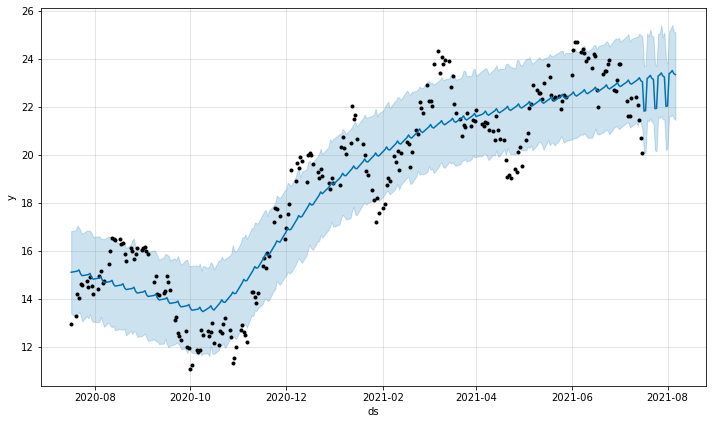

In [100]:
HAL=fcast('HAL')

In [65]:
HAL.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-17,14.826683,13.538495,16.790201,14.826683,14.826683,0.283366,0.283366,0.283366,0.283366,0.283366,0.283366,0.0,0.0,0.0,15.110049
1,2020-07-20,14.764850,13.408790,17.040655,14.764850,14.764850,0.379569,0.379569,0.379569,0.379569,0.379569,0.379569,0.0,0.0,0.0,15.144419
2,2020-07-21,14.744239,13.261790,16.947497,14.744239,14.744239,0.414044,0.414044,0.414044,0.414044,0.414044,0.414044,0.0,0.0,0.0,15.158283
3,2020-07-22,14.723629,13.467913,17.097819,14.723629,14.723629,0.484004,0.484004,0.484004,0.484004,0.484004,0.484004,0.0,0.0,0.0,15.207633
4,2020-07-23,14.703018,13.181809,16.964910,14.703018,14.703018,0.341208,0.341208,0.341208,0.341208,0.341208,0.341208,0.0,0.0,0.0,15.044226


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


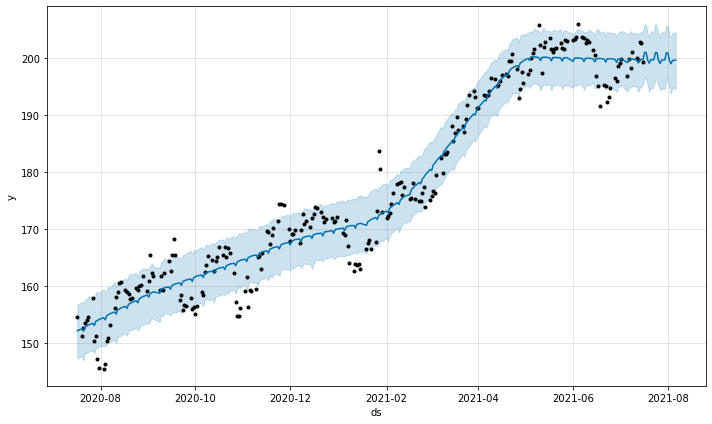

In [101]:
MMM=fcast('MMM')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


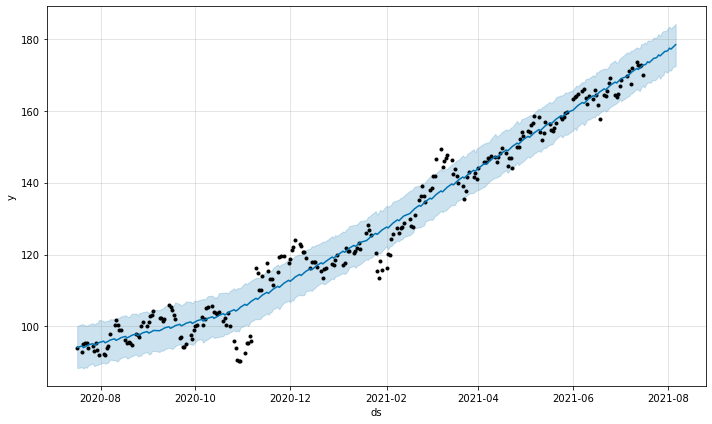

In [102]:
AXP=fcast('AXP')

In [66]:
def pred_4():
    """This function will prompt the user to input 4 different stock/ETF symbols. It will then use Prophet 
    to forecast the next 21 days of the stock price, and return the values (in percent) of potential gain and loss."""
    stocks=[]
    pcts=[]
    stock1,stock2,stock3,stock4=input("Enter 4 stock symbols: ").split(",")
    stocks=[stock1,stock2,stock3,stock4]
    for stock in stocks:
        stock=stock.upper()
        df=fcast(stock)
        df1=df['yhat']
        df1=df1.tail(21)
        df1.reset_index(level=0, drop=True,inplace=True)
        change=((df1[20]-df1[0])/df1[0])*100
        change=round(change, 2)
        pcts.append(change)
    for i in range(0,4):
        print(f"Stock: {stocks[i].upper()}")
        print(f"Percent Change: {pcts[i]}")
    maxp=pcts.index(max(pcts))
    print()
    print(f'According to the model, {stocks[maxp].upper()} has the highest upside.')
    print("\n" * 3)
    print('FOR ENTERTAINMENT PURPOSES ONLY. This does not substitute for advise from a financial advisor.') 
    print('The creator and affiliates are not responsible for any potential losses. But totally responsible for any gains.')
    return None
    

In [67]:
pred_4()

Enter 4 stock symbols: fb,msft,amzn,googl


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Stock: FB
Percent Change: 3.17
Stock: MSFT
Percent Change: 3.51
Stock: AMZN
Percent Change: 4.83
Stock: GOOGL
Percent Change: 3.12

According to the model, AMZN has the highest upside.




FOR ENTERTAINMENT PURPOSES ONLY. This does not substitute for advise from a financial advisor.
The creator and affiliates are not responsible for any potential losses. But totally responsible for any gains.
